## CLASSIFICAÇÃO IRIS EVALUATION BINÁRIO

### PARAMETROS

In [1]:
# PARÂMETROS
random_seed = 42

# FEATURE SELECTION
center_stat = 'mean'
my_cols = ["petal_length", "petal_width"]  # sepal_length, sepal_width, petal_length, petal_width

# MY CLASS
my_class = 'versicolor' # setosa, virginica, versicolor

# KNN
k_min = 1
k_max = 11
distance_metric = 'euclidean'
weights = 'uniform'
holdout_size = 0.2
k_of_k_folds = 5

# GOURMET
palette = ['limegreen', 'indianred']

# EVALUATION
evaluation_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
evaluation_pick = 'f1_score'
picking_stat = 'all' # holdout, all

In [2]:
from itertools import product
from typing import Optional

import numpy
import pandas
import seaborn
from matplotlib import pyplot
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### IMPORT IRIS

In [3]:
iris_dict = load_iris()
iris = pandas.DataFrame(iris_dict['data'])
iris.columns = iris_dict['feature_names']
iris.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
iris['target'] = iris_dict['target']
iris['species'] = iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
iris['flower'] = iris['species'].apply(lambda x: my_class if x == my_class else 'aother')
iris['target'] = iris['flower'].apply(lambda x: 1 if x == my_class else 0)

iris

,sepal_length,sepal_width,petal_length,petal_width,target,species,flower
0,5.1,3.5,1.4,0.2,0,setosa,aother
1,4.9,3.0,1.4,0.2,0,setosa,aother
2,4.7,3.2,1.3,0.2,0,setosa,aother
3,4.6,3.1,1.5,0.2,0,setosa,aother
4,5.0,3.6,1.4,0.2,0,setosa,aother
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,virginica,aother
146,6.3,2.5,5.0,1.9,0,virginica,aother
147,6.5,3.0,5.2,2.0,0,virginica,aother
148,6.2,3.4,5.4,2.3,0,virginica,aother


### PAIRPLOT

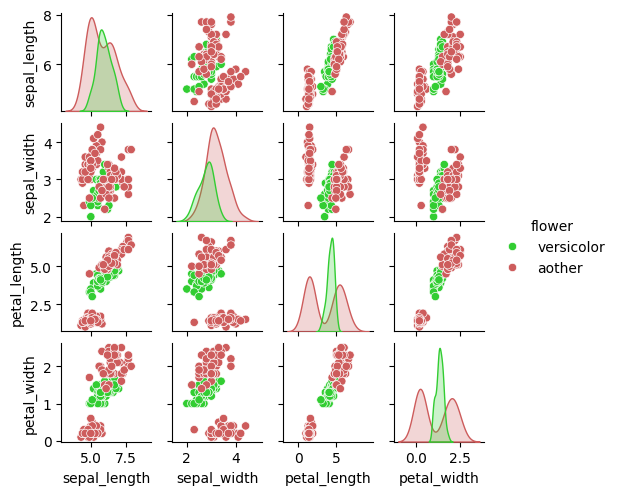

In [4]:
_ = seaborn.pairplot(iris[["sepal_length", "sepal_width", "petal_length", "petal_width", "flower"]],
                     hue='flower',
                     palette=palette,
                     height=1.25,
                     hue_order=[my_class, 'aother'])

### SELEÇÃO DO TOP 2 ATRIBUTOS

In [5]:
all_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
centers = iris.groupby(['flower'])[all_cols].agg(center_stat).T
max_diff = (centers.T.max() - centers.T.min()).sort_values(ascending=False)

max_diff

petal_length    0.753
sepal_width     0.431
petal_width     0.190
sepal_length    0.139
dtype: float64

In [6]:
x_cols_sorted = max_diff.index.tolist()[:2]

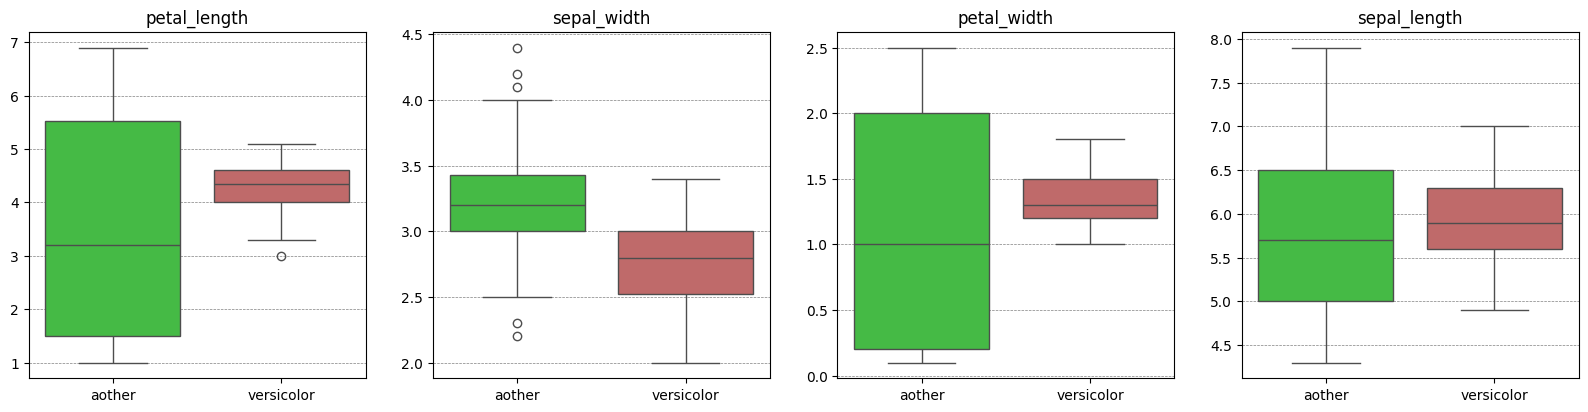

In [7]:
x_cols_sorted = max_diff.index.tolist()

# BOXPLOT DOS ATRIBUTOS VS CLASSE
fig, axs = pyplot.subplots(1, 4, figsize=(20, 4.5))
for i, ax in enumerate(axs.flatten()):
    seaborn.boxplot(x='flower', y=x_cols_sorted[i], data=iris, ax=ax, hue='flower', dodge=False, palette=palette)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(x_cols_sorted[i])
    ax.grid(which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)

In [8]:
if my_cols:
    x_cols = my_cols
else:
    x_cols = x_cols_sorted[:2]

x_cols

['petal_length', 'petal_width']

### LOOP DE TREINAMENTO

> TRAINING SIZE VS KNN (MÚLTIPLOS KS) VS REGRESSÃO LOGÍSTICA

In [9]:
metrics_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score
}

In [10]:
# RANDOM SEED
numpy.random.seed(random_seed)

# SEPARAR 20% DOS DADOS COMO HOLDOUT
iris_train : Optional[pandas.DataFrame] = None
iris_test : Optional[pandas.DataFrame] = None
iris_train, iris_test = train_test_split(iris, test_size=holdout_size, stratify=iris['target'], random_state=random_seed)

# LOOP DE TREINAMENTO
ks = range(k_max, k_min - 2, -2)
database_size_range = numpy.arange(0.05, 1.05, 0.05)

# LOOP DE TREINO
# PARA TODOS OS Ks, PARA FEATURES DE 1 A 4 E PARA TODOS OS FOLDS
ix_model = 0
model_list = []
for db_size in database_size_range:
    if db_size != 1.0:
        iris_sample, _ = train_test_split(iris_train, test_size=1.0 - db_size, stratify=iris_train['target'], random_state=random_seed)
    else:
        iris_sample = iris_train
    kfolds = StratifiedKFold(n_splits=k_of_k_folds, shuffle=True, random_state=random_seed)
    ix_fold = 0

    
    if iris_sample["target"].value_counts().min() < k_of_k_folds:
        continue  # Skip if not enough samples for k-folds

    for train_ix, val_ix in kfolds.split(iris_sample[x_cols], iris_sample['target']):
        X_train, y_train = iris_sample[x_cols].iloc[train_ix], iris_sample['target'].iloc[train_ix]
        X_val, y_val = iris_sample[x_cols].iloc[val_ix], iris_sample['target'].iloc[val_ix]

        # ESCALONAMENTO
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # TREINAMENTO KNN
        for k in ks:
            algorithm = 'KNN'
            model_name = f"KNN-{str(k).zfill(2)}-{100.0*db_size:.0f}-{ix_fold}"
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric, weights=weights)
            knn.fit(X_train_scaled, y_train)
            y_train_pred = knn.predict(X_train_scaled)
            y_val_pred = knn.predict(X_val_scaled)

            # metrics loop
            for metric in evaluation_metrics:
                if metric in metrics_dict:
                    # print(f"Treinando {model_name} com metrica {metric}...")
                    match metric:
                        case 'accuracy':
                            train_metric = metrics_dict[metric](y_train, y_train_pred)
                            val_metric = metrics_dict[metric](y_val, y_val_pred)
                        case _:
                            train_metric = metrics_dict[metric](y_train, y_train_pred)
                            val_metric = metrics_dict[metric](y_val, y_val_pred)

                    print(f"{model_name} @ {metric} > treino: {100.0*train_metric:.1f}% | val: {100.0*val_metric:.1f}%")
                    model_list.append({'ix_model': ix_model,
                                       'algorithm': algorithm,
                                       'hyperparameter': k,
                                       'db_size': db_size,
                                       'hdb' : f"K{str(k).zfill(2)}{100.0*db_size:.0f}",
                                       'fold': ix_fold,
                                       'model_name': model_name,
                                       'stat' : 'train',
                                       'metric': metric,
                                       'metric_value': train_metric,
                                       'scaler' : scaler,
                                       'model' : knn})
                    model_list.append({'ix_model': ix_model,
                                       'algorithm': algorithm,
                                       'hyperparameter': k,
                                       'db_size': db_size,
                                       'hdb' : f"K{str(k).zfill(2)}{100.0*db_size:.0f}",
                                       'fold': ix_fold,
                                       'model_name': model_name,
                                       'stat' : 'validation',
                                       'metric': metric,
                                       'metric_value': val_metric,
                                       'scaler' : scaler,
                                       'model' : knn})
                    
                else:
                    raise ValueError(f"Unknown metric: {metric}")

            ix_model += 1
        
        # TREINAMENTO LOGISTIC REGRESSION
        logreg = LogisticRegression(penalty=None,
                                    dual=False,
                                    class_weight='balanced',
                                    random_state=random_seed,
                                    solver='lbfgs',
                                    max_iter=1000)
        logreg.fit(X_train_scaled, y_train)
        y_train_pred = logreg.predict(X_train_scaled)
        y_val_pred = logreg.predict(X_val_scaled)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        algorithm = 'LGR'
        model_name = f"LGR-00-{100.0*db_size:.0f}-{ix_fold}"
        # metrics loop
        for metric in evaluation_metrics:
            if metric in metrics_dict:
                # print(f"Treinando {model_name} com metrica {metric}...")
                match metric:
                    case 'accuracy':
                        train_metric = metrics_dict[metric](y_train, y_train_pred)
                        val_metric = metrics_dict[metric](y_val, y_val_pred)
                    case _:
                        train_metric = metrics_dict[metric](y_train, y_train_pred)
                        val_metric = metrics_dict[metric](y_val, y_val_pred)
                print(f"{model_name} @ {metric} > treino: {100.0*train_metric:.1f}% | val: {100.0*val_metric:.1f}%")
                model_list.append({'ix_model': ix_model,
                                   'algorithm': algorithm,
                                   'hyperparameter': None,
                                   'db_size': db_size,
                                   'hdb' : f"L00{100.0*db_size:.0f}",
                                   'fold': ix_fold,
                                   'model_name': model_name,
                                   'stat' : 'train',
                                   'metric': metric,
                                   'metric_value': train_metric,
                                   'scaler' : scaler,
                                   'model' : logreg})
                model_list.append({'ix_model': ix_model,
                                   'algorithm': algorithm,
                                   'hyperparameter': None,
                                   'db_size': db_size,
                                   'hdb' : f"L00{100.0*db_size:.0f}",
                                   'fold': ix_fold,
                                   'model_name': model_name,
                                   'stat' : 'validation',
                                   'metric': metric,
                                   'metric_value': val_metric,
                                   'scaler' : scaler,
                                   'model' : logreg})
            else:
                raise ValueError(f"Unknown metric: {metric}")
        ix_model += 1
        ix_fold += 1


KNN-11-15-0 @ accuracy > treino: 71.4% | val: 50.0%
KNN-11-15-0 @ precision > treino: 0.0% | val: 0.0%
KNN-11-15-0 @ recall > treino: 0.0% | val: 0.0%
KNN-11-15-0 @ f1_score > treino: 0.0% | val: 0.0%
KNN-09-15-0 @ accuracy > treino: 71.4% | val: 50.0%
KNN-09-15-0 @ precision > treino: 0.0% | val: 0.0%
KNN-09-15-0 @ recall > treino: 0.0% | val: 0.0%
KNN-09-15-0 @ f1_score > treino: 0.0% | val: 0.0%
KNN-07-15-0 @ accuracy > treino: 100.0% | val: 75.0%
KNN-07-15-0 @ precision > treino: 100.0% | val: 66.7%
KNN-07-15-0 @ recall > treino: 100.0% | val: 100.0%
KNN-07-15-0 @ f1_score > treino: 100.0% | val: 80.0%
KNN-05-15-0 @ accuracy > treino: 100.0% | val: 75.0%
KNN-05-15-0 @ precision > treino: 100.0% | val: 66.7%
KNN-05-15-0 @ recall > treino: 100.0% | val: 100.0%
KNN-05-15-0 @ f1_score > treino: 100.0% | val: 80.0%
KNN-03-15-0 @ accuracy > treino: 100.0% | val: 75.0%


c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\minic

KNN-03-15-0 @ precision > treino: 100.0% | val: 66.7%
KNN-03-15-0 @ recall > treino: 100.0% | val: 100.0%
KNN-03-15-0 @ f1_score > treino: 100.0% | val: 80.0%
KNN-01-15-0 @ accuracy > treino: 100.0% | val: 75.0%
KNN-01-15-0 @ precision > treino: 100.0% | val: 66.7%
KNN-01-15-0 @ recall > treino: 100.0% | val: 100.0%
KNN-01-15-0 @ f1_score > treino: 100.0% | val: 80.0%
LGR-00-15-0 @ accuracy > treino: 78.6% | val: 75.0%
LGR-00-15-0 @ precision > treino: 60.0% | val: 100.0%
LGR-00-15-0 @ recall > treino: 75.0% | val: 50.0%
LGR-00-15-0 @ f1_score > treino: 66.7% | val: 66.7%
KNN-11-15-1 @ accuracy > treino: 64.3% | val: 75.0%
KNN-11-15-1 @ precision > treino: 0.0% | val: 0.0%
KNN-11-15-1 @ recall > treino: 0.0% | val: 0.0%
KNN-11-15-1 @ f1_score > treino: 0.0% | val: 0.0%
KNN-09-15-1 @ accuracy > treino: 78.6% | val: 25.0%
KNN-09-15-1 @ precision > treino: 62.5% | val: 25.0%
KNN-09-15-1 @ recall > treino: 100.0% | val: 100.0%
KNN-09-15-1 @ f1_score > treino: 76.9% | val: 40.0%
KNN-07-15-1

c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\minic

KNN-01-15-1 @ precision > treino: 100.0% | val: 100.0%
KNN-01-15-1 @ recall > treino: 100.0% | val: 100.0%
KNN-01-15-1 @ f1_score > treino: 100.0% | val: 100.0%
LGR-00-15-1 @ accuracy > treino: 85.7% | val: 25.0%
LGR-00-15-1 @ precision > treino: 80.0% | val: 25.0%
LGR-00-15-1 @ recall > treino: 80.0% | val: 100.0%
LGR-00-15-1 @ f1_score > treino: 80.0% | val: 40.0%
KNN-11-15-2 @ accuracy > treino: 64.3% | val: 75.0%
KNN-11-15-2 @ precision > treino: 0.0% | val: 0.0%
KNN-11-15-2 @ recall > treino: 0.0% | val: 0.0%
KNN-11-15-2 @ f1_score > treino: 0.0% | val: 0.0%
KNN-09-15-2 @ accuracy > treino: 78.6% | val: 25.0%
KNN-09-15-2 @ precision > treino: 62.5% | val: 25.0%
KNN-09-15-2 @ recall > treino: 100.0% | val: 100.0%
KNN-09-15-2 @ f1_score > treino: 76.9% | val: 40.0%
KNN-07-15-2 @ accuracy > treino: 71.4% | val: 25.0%
KNN-07-15-2 @ precision > treino: 55.6% | val: 25.0%
KNN-07-15-2 @ recall > treino: 100.0% | val: 100.0%
KNN-07-15-2 @ f1_score > treino: 71.4% | val: 40.0%
KNN-05-15-2 

c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KNN-03-15-3 @ accuracy > treino: 93.3% | val: 100.0%
KNN-03-15-3 @ precision > treino: 83.3% | val: 100.0%
KNN-03-15-3 @ recall > treino: 100.0% | val: 100.0%
KNN-03-15-3 @ f1_score > treino: 90.9% | val: 100.0%
KNN-01-15-3 @ accuracy > treino: 100.0% | val: 100.0%
KNN-01-15-3 @ precision > treino: 100.0% | val: 100.0%
KNN-01-15-3 @ recall > treino: 100.0% | val: 100.0%
KNN-01-15-3 @ f1_score > treino: 100.0% | val: 100.0%
LGR-00-15-3 @ accuracy > treino: 66.7% | val: 66.7%
LGR-00-15-3 @ precision > treino: 50.0% | val: 50.0%
LGR-00-15-3 @ recall > treino: 80.0% | val: 100.0%
LGR-00-15-3 @ f1_score > treino: 61.5% | val: 66.7%
KNN-11-15-4 @ accuracy > treino: 66.7% | val: 66.7%
KNN-11-15-4 @ precision > treino: 0.0% | val: 0.0%
KNN-11-15-4 @ recall > treino: 0.0% | val: 0.0%
KNN-11-15-4 @ f1_score > treino: 0.0% | val: 0.0%


c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KNN-09-15-4 @ accuracy > treino: 73.3% | val: 33.3%
KNN-09-15-4 @ precision > treino: 55.6% | val: 33.3%
KNN-09-15-4 @ recall > treino: 100.0% | val: 100.0%
KNN-09-15-4 @ f1_score > treino: 71.4% | val: 50.0%
KNN-07-15-4 @ accuracy > treino: 93.3% | val: 100.0%
KNN-07-15-4 @ precision > treino: 83.3% | val: 100.0%
KNN-07-15-4 @ recall > treino: 100.0% | val: 100.0%
KNN-07-15-4 @ f1_score > treino: 90.9% | val: 100.0%
KNN-05-15-4 @ accuracy > treino: 100.0% | val: 100.0%
KNN-05-15-4 @ precision > treino: 100.0% | val: 100.0%
KNN-05-15-4 @ recall > treino: 100.0% | val: 100.0%
KNN-05-15-4 @ f1_score > treino: 100.0% | val: 100.0%
KNN-03-15-4 @ accuracy > treino: 93.3% | val: 100.0%
KNN-03-15-4 @ precision > treino: 83.3% | val: 100.0%
KNN-03-15-4 @ recall > treino: 100.0% | val: 100.0%
KNN-03-15-4 @ f1_score > treino: 90.9% | val: 100.0%
KNN-01-15-4 @ accuracy > treino: 100.0% | val: 100.0%
KNN-01-15-4 @ precision > treino: 100.0% | val: 100.0%
KNN-01-15-4 @ recall > treino: 100.0% | val

In [11]:
results = pandas.DataFrame(model_list)
results

,ix_model,algorithm,hyperparameter,db_size,hdb,fold,model_name,stat,metric,metric_value,scaler,model
0,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,train,accuracy,0.714286,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
1,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,validation,accuracy,0.500000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
2,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,train,precision,0.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
3,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,validation,precision,0.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,train,recall,0.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5035,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,validation,precision,0.545455,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."
5036,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,train,recall,0.750000,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."
5037,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,validation,recall,0.750000,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."
5038,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,train,f1_score,0.695652,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."


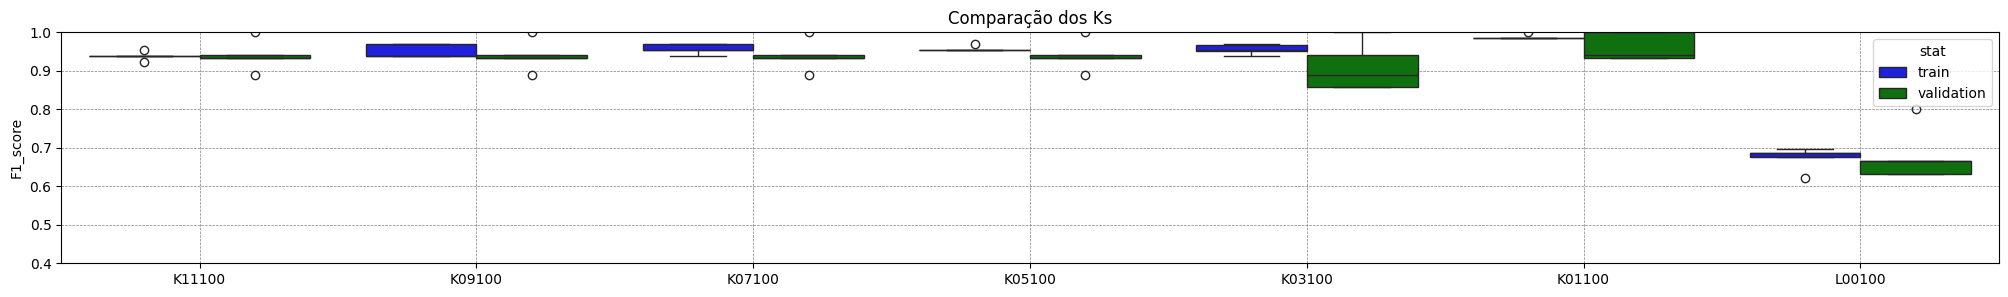

In [12]:
ix_db_size = results.db_size == 1.0
ix_evaluation_pick = results.metric == evaluation_pick
ix_results = ix_db_size & ix_evaluation_pick

fig = pyplot.figure(figsize=(25, 3))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='hdb', y='metric_value', data=results.loc[ix_results, :], hue='stat', palette=['blue', 'green'], ax=ax, hue_order=['train', 'validation'])
ax.set_title('Comparação dos Ks')
ax.set_ylabel(f'{evaluation_pick.capitalize()}')
ax.set_xlabel('')
ax.set_ylim(0.4, 1.0)
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

### PICK DO MELHOR K

In [13]:
ix_validation = results["stat"] == "validation"
ix_knn = results["algorithm"] == "KNN"
ix_dbsize = results["db_size"] == 1.0
ix_evaluation_pick = results["metric"] == evaluation_pick
ix_best_k = ix_validation & ix_knn & ix_dbsize & ix_evaluation_pick

mean_metric_by_kf = results.loc[ix_best_k, ["hyperparameter", "hdb", "metric_value"]].groupby(["hyperparameter", "hdb"]).agg(["mean", "min"]).reset_index()
mean_metric_by_kf.columns = ['h', 'hdb', f'mean_{evaluation_pick}', f'min_{evaluation_pick}']
mean_metric_by_kf = mean_metric_by_kf.sort_values(by=['h', f'mean_{evaluation_pick}', f'min_{evaluation_pick}'], ascending=[False, False, False])
mean_metric_by_kf

,h,hdb,mean_f1_score,min_f1_score
5,11.0,K11100,0.939346,0.888889
4,9.0,K09100,0.939346,0.888889
3,7.0,K07100,0.939346,0.888889
2,5.0,K05100,0.939346,0.888889
1,3.0,K03100,0.908870,0.857143
0,1.0,K01100,0.961569,0.933333


In [14]:
results.loc[ix_validation & ix_knn & ix_dbsize, :].sort_values(by='metric_value')

,ix_model,algorithm,hyperparameter,db_size,hdb,fold,model_name,stat,metric,metric_value,scaler,model
4853,606,KNN,3.0,1.0,K03100,1,KNN-03-100-1,validation,recall,0.75,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
5021,627,KNN,3.0,1.0,K03100,4,KNN-03-100-4,validation,recall,0.75,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4899,612,KNN,5.0,1.0,K05100,2,KNN-05-100-2,validation,precision,0.80,StandardScaler(),KNeighborsClassifier(metric='euclidean')
4875,609,KNN,11.0,1.0,K11100,2,KNN-11-100-2,validation,precision,0.80,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4891,611,KNN,7.0,1.0,K07100,2,KNN-07-100-2,validation,precision,0.80,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,624,KNN,9.0,1.0,K09100,4,KNN-09-100-4,validation,precision,1.00,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
5011,626,KNN,5.0,1.0,K05100,4,KNN-05-100-4,validation,precision,1.00,StandardScaler(),KNeighborsClassifier(metric='euclidean')
5003,625,KNN,7.0,1.0,K07100,4,KNN-07-100-4,validation,precision,1.00,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
5019,627,KNN,3.0,1.0,K03100,4,KNN-03-100-4,validation,precision,1.00,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."


### RETREINO MELHOR K

In [15]:
best_k = mean_metric_by_kf.iloc[0, :]['h']
# RETRAIN MODEL WITH ALL TRAINING + VALIDATION
best_k_scaler = StandardScaler()
X_best_k_scaled = best_k_scaler.fit_transform(iris_train[x_cols])
y_best_k = iris_train['target']
best_k_knn = KNeighborsClassifier(n_neighbors=int(best_k), metric=distance_metric, weights=weights)
best_k_knn.fit(X_best_k_scaled, y_best_k)
y_best_k_pred = best_k_knn.predict(X_best_k_scaled)
knn_retrain_metric = metrics_dict[evaluation_pick](y_best_k, y_best_k_pred)
print(f"Modelo KNN retreinado com K={best_k} @ {evaluation_pick} > treino: {100.0*knn_retrain_metric:.1f}%")

Modelo KNN retreinado com K=11.0 @ f1_score > treino: 95.1%


### RETREINO REGRESSÃO LOGÍSTICA

In [16]:
reg_log_scaler = StandardScaler()
X_reg_log_scaled = reg_log_scaler.fit_transform(iris_train[x_cols])
y_reg_log = iris_train['target']

retrain_logreg = LogisticRegression(penalty=None,
                                    dual=False,
                                    class_weight='balanced',
                                    random_state=random_seed,
                                    solver='lbfgs',
                                    max_iter=1000)
retrain_logreg.fit(X_reg_log_scaled, y_reg_log)
y_reg_log_pred = retrain_logreg.predict(X_reg_log_scaled)
log_reg_retrain_metric = metrics_dict[evaluation_pick](y_reg_log, y_reg_log_pred)
print(f"Modelo LGR retreinado @ {evaluation_pick} > treino: {100.0*train_accuracy:.1f}%")

Modelo LGR retreinado @ f1_score > treino: 78.1%


### CANDIDATOS: RETREINOS + MELHOR FOLDS

In [17]:
# best_k_knn, retrain_logreg
ix_dbsize = results["db_size"] == 1.0
ix_knn = results["algorithm"] == "KNN"
ix_best_hyperparameter = results["hyperparameter"] == best_k
ix_validation = results["stat"] == "validation"
ix_evaluation_pick = results["metric"] == evaluation_pick
ix_best_k = ix_dbsize & ix_knn & ix_best_hyperparameter & ix_validation & ix_evaluation_pick

best_k_fold_row = results.loc[ix_best_k, :].sort_values(by='metric_value', ascending=False).iloc[0, :]
best_k_fold_scaler = best_k_fold_row['scaler']
best_k_fold_knn = best_k_fold_row['model']

best_k_fold_knn

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [18]:
ix_dbsize = results["db_size"] == 1.0
ix_logreg = results["algorithm"] == "LGR"
ix_validation = results["stat"] == "validation"
ix_evaluation_pick = results["metric"] == evaluation_pick
ix_best_logreg = ix_dbsize & ix_logreg & ix_validation & ix_evaluation_pick

best_logreg_fold_row = results.loc[ix_best_logreg, :].sort_values(by='metric_value', ascending=False).iloc[0, :]
best_logreg_fold_scaler = best_logreg_fold_row['scaler']
best_logreg_fold_lgr = best_logreg_fold_row['model']

best_logreg_fold_lgr

LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None,
                   random_state=42)

### ERRO HOLDOUT ERRO ALL PARA OS CANDIDATOS

In [19]:
candidate_models = [("KNN", "RETRAIN", best_k_scaler, best_k_knn), 
                    ("LGR", "RETRAIN", reg_log_scaler, retrain_logreg),
                    ("KNN", "FOLD", best_k_fold_scaler, best_k_fold_knn),
                    ("LGR", "FOLD", best_logreg_fold_scaler, best_logreg_fold_lgr)]

# CALCULATE HOLDOUT AND ALL ACCURACY
holdout_results = []
for algorithm, config, scaler, model in candidate_models:
    X_test_scaled = scaler.transform(iris_test[x_cols])
    y_test = iris_test['target']
    X_all_scaled = scaler.transform(iris[x_cols])
    y_all = iris['target']
    y_test_pred = model.predict(X_test_scaled)
    y_all_pred = model.predict(X_all_scaled)
    test_metric = metrics_dict[evaluation_pick](y_test, y_test_pred)
    all_metric = metrics_dict[evaluation_pick](y_all, y_all_pred)

    holdout_results.append({'algorithm': algorithm,
                            'config': config,
                            'stat': 'holdout',
                            'metric': evaluation_pick,
                            'metric_value': test_metric,
                            'model': model,
                            'scaler': scaler})
    holdout_results.append({'algorithm': algorithm,
                            'config': config,
                            'stat': 'all',
                            'metric': evaluation_pick,
                            'metric_value': all_metric,
                            'model': model,
                            'scaler': scaler})
    
holdout_results = pandas.DataFrame(holdout_results)
holdout_results = holdout_results.sort_values(by='metric_value', ascending=False)
holdout_results

,algorithm,config,stat,metric,metric_value,model,scaler
1,KNN,RETRAIN,all,f1_score,0.941176,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
5,KNN,FOLD,all,f1_score,0.930693,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
4,KNN,FOLD,holdout,f1_score,0.900000,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
0,KNN,RETRAIN,holdout,f1_score,0.900000,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
2,LGR,RETRAIN,holdout,f1_score,0.782609,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
6,LGR,FOLD,holdout,f1_score,0.720000,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
7,LGR,FOLD,all,f1_score,0.705882,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
3,LGR,RETRAIN,all,f1_score,0.690265,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()


### PICK DO MELHOR MODELO

In [20]:
best_model_row = holdout_results.loc[holdout_results['stat'] == picking_stat, :].sort_values(by='metric_value', ascending=False).iloc[0, :]
# best_model_row = holdout_results.loc[(holdout_results['config'] == 'FOLD') & (holdout_results['stat'] == 'all') & (holdout_results['algorithm'] == 'LGR') , :].sort_values(by='metric_value', ascending=False).iloc[0, :]
best_model_row

algorithm                                                     KNN
config                                                    RETRAIN
stat                                                          all
metric                                                   f1_score
metric_value                                             0.941176
model           KNeighborsClassifier(metric='euclidean', n_nei...
scaler                                           StandardScaler()
Name: 1, dtype: object

In [21]:
best_model = best_model_row['model']
best_model_scaler = best_model_row['scaler']

print(f"Melhor modelo: {best_model_row['algorithm']} - {best_model_row['config']} > holdout: {100.0*best_model_row['metric_value']:.1f}%, all: {100.0*holdout_results.loc[holdout_results['stat'] == 'all', 'metric_value'].max():.1f}%")

Melhor modelo: KNN - RETRAIN > holdout: 94.1%, all: 94.1%


### Matriz de Confusão

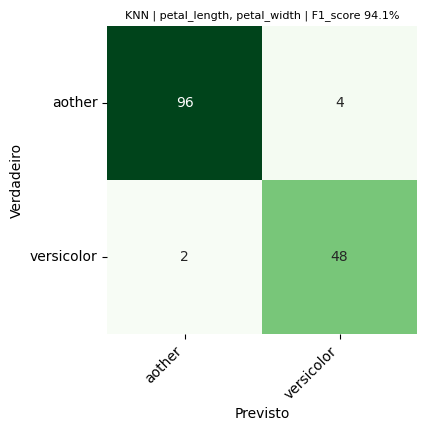

In [22]:
Xs = best_model_scaler.transform(iris[x_cols])
y = iris['target']
winner_y_pred = best_model.predict(Xs)

fig = pyplot.figure(figsize=(4, 4))
# PLOT CONFUSION MATRIX
conf_matrix = confusion_matrix(y, winner_y_pred)

ax = fig.add_subplot(111)
_ = seaborn.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, ax=ax)
_ = ax.set_xlabel('Previsto')
_ = ax.set_ylabel('Verdadeiro')
_ = ax.set_xticklabels(iris['flower'].unique(), rotation=45, ha='right')
_ = ax.set_yticklabels(iris['flower'].unique(), rotation=0, ha='right')
best_feat_string = ', '.join(x_cols)
_ = ax.set_title(f'{best_model_row['algorithm']} | {best_feat_string} | {evaluation_pick.capitalize()} {100.0*best_model_row['metric_value']:.1f}%', size=8)

### SUPERFÍCIE DE SEPARAÇÃO

In [23]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 500
species = sorted(iris['flower'].unique().tolist())

# X0 W JITTER
X_plot = iris[x_cols].to_numpy()
x0_grid = numpy.linspace(0, X_plot[:, 0].max(), grid_n_points)
x1_grid = numpy.linspace(0, X_plot[:, 1].max(), grid_n_points)
X_g = numpy.array(list(product(x0_grid, x1_grid)))
X_g_scaled = best_model_scaler.transform(X_g)
Y_g = best_model.predict(X_g_scaled)
Y_g_class = numpy.array([species[x] for x in Y_g])
Y_est = best_model.predict(Xs)
Y_class_est = numpy.array([species[x] for x in Y_est])

c:\Users\User\miniconda3\envs\infnet-ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [24]:
color_list = ['red', 'green']
background_color_list = ['lightcoral', 'limegreen']
marker_list = ['v', '^']

# GIVE COLOURS TO CLASS
color_dict = {}
bg_color_dict = {}
marker_dict = {}
ix_color = 0
for specie in species:
    color_dict[specie] = color_list[ix_color]
    marker_dict[specie] = marker_list[ix_color]
    bg_color_dict[specie] = background_color_list[ix_color]
    ix_color += 1

color_dict

{'aother': 'red', 'versicolor': 'green'}

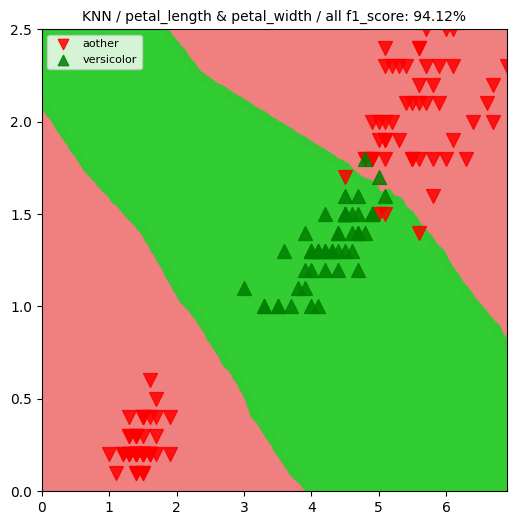

In [25]:
# CLASSIFICATION FIGURE
fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# PLOT CLASS REGION
for specie in species:
    ix_class_cloud = Y_g_class == specie
    x_0_cloud = X_g[ix_class_cloud, 0]
    x_1_cloud = X_g[ix_class_cloud, 1]
    _ = ax.scatter(x_0_cloud, x_1_cloud, marker='o', color=bg_color_dict[specie], alpha=0.25)

# PLOR FLOWERS
for specie in species:
    ix_class = iris['flower'] == specie
    x_0 = X_plot[ix_class, 0]
    x_1 = X_plot[ix_class, 1]
    _ = ax.scatter(x_0, x_1, color=color_dict[specie], marker=marker_dict[specie], alpha=0.85, s=100, label=specie)
    _ = ax.legend(loc='upper left', fontsize=8, markerscale=0.75)
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title(f"{best_model_row['algorithm']} / {' & '.join(x_cols)} / {picking_stat} {best_model_row['metric']}: {100.0*best_model_row['metric_value']:.2f}%", size=10)

CONFUSÃO + ROC + SUPERFÍCIE DE SEPARAÇÃO MELHOR MODELO

LEARNING CURVE MELHOR K VS REGRESSÃO LOGÍSTICA

FLUTUAÇÃO DOS PARÂMETROS DA REGRESSÃO LOGÍSTICA